In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('../input/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.shape

(5110, 12)

# Exploratory Data Analysis 

In [4]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
# We can get the probability that the person would have a stroke.
# Second we need to check the number of false negative our model gives 
# In cases of medical models it is very very important to keep an eye on false positives and false negatives

In [6]:
# What is the ratio of male to female patients 
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

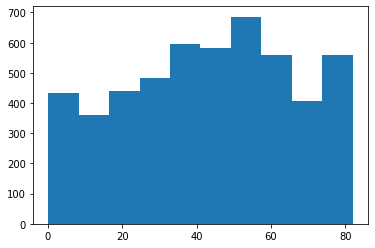

In [7]:
# What is the histogram of age
plt.hist(x = df['age'],bins=10);

In [8]:
df.hypertension.value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [9]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [10]:
249/4861

0.051224027977782347

In [11]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

/home/abhilash/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/abhilash/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


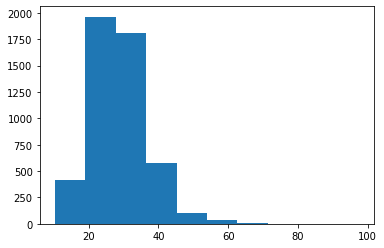

In [12]:
plt.hist(df['bmi']);

In [13]:
df['bmi'] = df['bmi'].fillna(np.mean(df['bmi']))

In [14]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [15]:
# Accuracy 
# We are going to be looking roc_auc_score

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [17]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [18]:
features =  [f for f in df.columns if f not in ('id','stroke')]
print(features)

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']


In [19]:
categorical_features = [f for f in features if df[f].dtype==object]
print(categorical_features)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [20]:
numerical_features = [f for f in features if df[f].dtype!=object]
print(numerical_features)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


In [21]:
preprocess = make_column_transformer((OneHotEncoder(),categorical_features),(StandardScaler(),numerical_features))

In [22]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.4)

In [23]:
rf = RandomForestClassifier()

In [24]:
steps = [('preprocess',preprocess),('over',over),('under',under),('rf',rf)]

In [25]:
pipe = Pipeline(steps=steps)

In [26]:
y = df.stroke.values

In [27]:
x_train,x_valid,y_train,y_valid = train_test_split(df[features],y,stratify=y,test_size=0.2,random_state=54)

In [28]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi'])])),
                ('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.4)),
               

In [29]:
y_pred_prob = pipe.predict_proba(x_valid)[:,1]

In [30]:
from sklearn.metrics import confusion_matrix,roc_auc_score

In [31]:
roc = roc_auc_score(y_valid,y_pred_prob)
print('The AUC Score : {:.3f}'.format(roc))

The AUC Score : 0.827


In [32]:
y_pred = pipe.predict(x_valid)

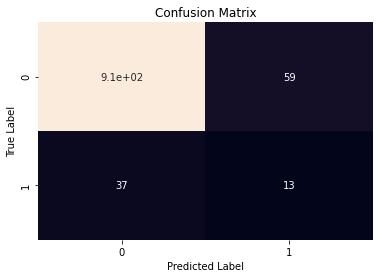

In [33]:
cm = confusion_matrix(y_valid,y_pred)
ax = sns.heatmap(cm,annot=True,cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');

In [34]:
fn = 0
for i,j in zip(y_valid,y_pred):
    if i==1 and j==0:
        fn+=1

In [35]:
fn

37

In [37]:
for f in categorical_features:
    print(df[f].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
